# Random forest model Trainen

In dit notebook zal er een random forest model getraint worden om te bepalen of er een omslagpunt te voorspellen is.

Er is gekozen voor Random Forest, omdat andere projectteamleden zich al richten op gradient boosting-algoritmes zoals XGBoost en LightGBM. Met Random Forest wil ik een ander type algoritme uitproberen, zodat we kunnen zien hoe een tree-based algoritme presteert in vergelijking met de gradient boosting.

Random Forest heeft potentie omdat het patronen in de data kan herkennen, goed omgaat met niet-lineaire relaties tussen features en target en robuust is tegen ruis door het gebruik van meerdere bomen. Daarnaast dient het model als een betrouwbare baseline, waarmee de prestaties van meer complexe modellen later beter kunnen worden geëvalueerd.

## Imports

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_val_predict, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, classification_report, confusion_matrix, ConfusionMatrixDisplay


import sys
from pathlib import Path
current_dir = Path.cwd()
project_dir = current_dir.parent. parent
sys.path.append(str(project_dir))
from pipeline import prepare_data, undersample, markeer_omslagpunten

## Data inladen

We werken met data:
- van 1 meetpunt: `RWS01_MONIBAS_0121hrr0288ra`
- over een tijdspanne van `2022-12-15` tot `2025-12-15`
- met een tijdsaggregatie van 5 min

In dit geval wordt er gebruik gemaakt van maar 1 punt, omdat het verkeerspatroon kan verschillen met locatie. Er is voor dit punt gekozen omdat deze een significant aantal file waarnemingen had.<br>

In [3]:
df = pd.read_csv("../../data/export_location_modeling/export_location_modeling.csv", low_memory=False)

<img src="../Images/Geselecteerde locaties_modeling.png" alt="Geselecteerde locaties" />


## Data voorbereiden

De data wordt eerst opgeschoond met de bestaande pipeline de volgende acties uitvoert:

- Ongeldige metingen worden verwijdert (-1 waarden)
- Technical Exclusions & naam kolommen worden verwijderd
- Lage intensiteiten worden gefilterd (< 50 vtg/uur)
- Tijd wordt geconverteerd naar een integer
- Datum wordt omgezet naar datetime
- Er wordt een dag van de week kolom gemaakt
- Intensiteit en snelheid worden gesmooth
- Geografische data toevoegt aan de dataset
- Het omslagpunt wordt berekent

In [11]:
df_prepped = prepare_data(df)
df_clean   = markeer_omslagpunten(df_prepped)

Totaal gedetecteerde files: 698
-----------------------------------------------------
Detected files (unique file_id): 698
Marked omslagpunten:             698
-----------------------------------------------------


## Features & target

Target:
* `file_omslag_flag`: De kolom die als boolean aangeeft of er sprake is van een omslagpunt.

Features:
* `tijd`: Files volgen een dagelijkse cyclus, met duidelijke ochtend- en avondspitsen. Door tijd op te nemen kan het model deze patronen leren herkennen.
* `gem_intensiteit_smooth`: Structurele files ontstaan bij hoge verkeersbelasting. Het gebruik van een gesmoothde intensiteit helpt korte, tijdelijke fluctuaties te negeren, zodat het model zich richt op terugkerende congestie.
* `day_of_week`: Files vertonen wekelijkse patronen; in weekenden is het doorgaans rustiger dan op weekdagen. Daarom gebruiken we weekdag in plaats van exacte datum. In combinatie met tijd kan het model mogelijk ook spitsmomenten herkennen.

Ook is er binnen het projectteam sprake geweest van het meenemen van de feature `snelheid`, hierop is bepaald dat dit geen geldige feature is om mee te nemen, omdat dit onbekende info is op het moment van voorspelling. Als er van te voren bekend is dat de snelheid 20 km/h zal zijn is dit natuurlijk een duidelijke indicator dat er file zal zijn, maar deze info is net zo goed een target variabele als het omslagpunt.

**NOTE**: Het gebruik van de sinus en cosinus van tijd zou hier nog beter zijn, omdat het model dan herkent dat het daadwerkelijk een cyclus is, i.p.v. dat het hele patroon als het ware reset op 00:00. Wegens een tijdsnoot is er besloten deze niet mee te nemen.

In [12]:
X_columns = ['tijd', 'gem_intensiteit_smooth', 'day_of_week']
y_columns = 'file_omslag_flag'


## Test en validatieset 

### Testset
Nu leggen we testvariabele apart, zodat we achteraf kunnen testen of het model ook goed presteert op 'werkelijke' data. Normaal zou dit onaangeraakte data zijn, maar in dit geval is het essentieel dat we een target variabele hebben, waardoor prepare data wel van te voren aangeroepen moet worden. Er wordt wel expliciet gekozen om deze testset niet in de resampling mee te nemen, omdat dit het beeld van de werkelijkheid verstoord.

In [13]:
df_train, df_test = train_test_split(df_clean, test_size=0.25, random_state=8, shuffle=True)

X_test = df_test[X_columns]
y_test = df_test[y_columns]

### Validatie set

Om te valideren tijdens het trainen maak ik gebruik van crossvalidation. Dit zorgt ervoor dat er zo min mogelijk toevalligheden worden meegenomen tijdens het trainen. Denk hierbij vooral aan dingen zoals alleen data uit weekenden meenemen, of data vanuit dezelfde tijdstippen.

## Resamplen

Een essentiële stap in de data-preparatie is het balanceren van de dataset. Momenteel is het aantal momenten zonder file significant groter dan het aantal momenten met file. Deze schuine verdeling creëert een bias, waardoor het model geneigd is files te negeren. Dit bleek uit de resultaten van de Decision Tree Regressor in de eerste sprint (zie *data_analysis_team_panda* in de repository of *groepsproduct* uit sprint 1), waarbij filegedrag niet werd herkend. Dezelfde conclusie werd getrokken uit de simpele decision tree die features tijd en dag van de week ook mee nam (zie *XGBoost.ipynb*).

Om de recall te verbeteren, passen we daarom resampling toe

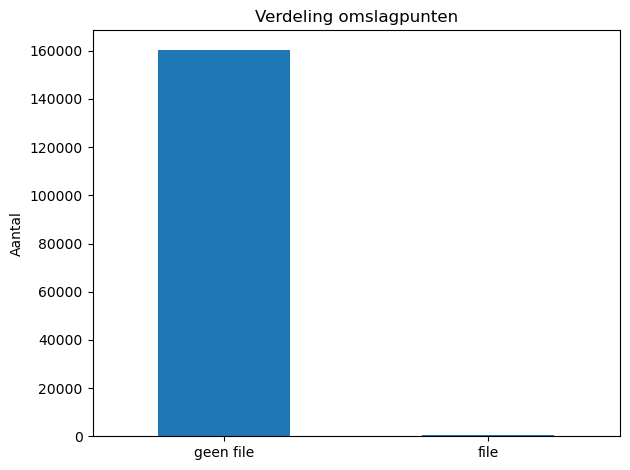

Ratio per class:
file_omslag_flag
geen file    0.996763
file         0.003237
Name: count, dtype: float64


In [14]:
counts = df_train['file_omslag_flag'].value_counts().sort_index()
counts.index = counts.index.map({0: 'geen file', 1: 'file'})

# Barplot
plt.figure()
counts.plot(kind='bar')
plt.xticks(rotation=0)
plt.xlabel('')
plt.ylabel('Aantal')
plt.title('Verdeling omslagpunten')
plt.tight_layout()
plt.show()

print("Ratio per class:")
print(counts / counts.sum())


De ratio is nu ongeveer 1 file voor 300 normale metingen. Om deze reden brengen we de ratio van de trainset naar slechts 3 normale momenten voor elk file moment. Dit wordt gedaan aan de hand van undersamplen: er worden willekeurige momenten waarop er geen file was uit de dataset gehaald, zodat de ratio naar beneden gebracht wordt.

In [15]:
def undersample(df, minority_class=1, ratio=3, random=17):
    df_minority = df[df["file_omslag_flag"] == minority_class].copy()
    df_majority = df[df["file_omslag_flag"] != minority_class].copy()
    n_minority = len(df_minority)
    n_majority_target = int(n_minority * ratio)
    df_majority_undersampled = df_majority.sample(n=n_majority_target,random_state=random)
    df_undersampled = pd.concat([df_minority, df_majority_undersampled], ignore_index=True)    
    return df_undersampled

Hier is een korte functie voor geschreven die ook te vinden is in de pipeline. Deze passen we toe.

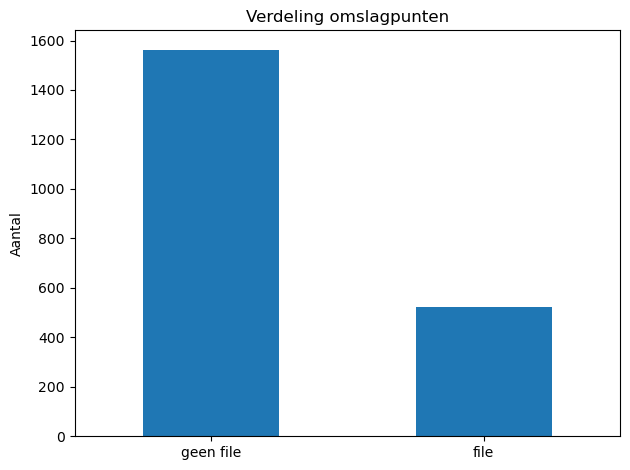

Ratio per class:
file_omslag_flag
geen file    0.75
file         0.25
Name: count, dtype: float64


In [16]:
# resample data
df_train_balanced = undersample(df_train, minority_class=1, ratio=3, random=17)

# define X and y train
X_train = df_train_balanced[X_columns]
y_train = df_train_balanced[y_columns]

# visualize new ratio
counts = y_train.value_counts().sort_index()
counts.index = counts.index.map({0: 'geen file', 1: 'file'})

# Barplot
plt.figure()
counts.plot(kind='bar')
plt.xticks(rotation=0)
plt.xlabel('')
plt.ylabel('Aantal')
plt.title('Verdeling omslagpunten')
plt.tight_layout()
plt.show()

print("Ratio per class:")
print(counts / counts.sum())


Nu zijn de niet-file momenten verminderd naar 1500 en zijn filemomenten minder zeldzaam in de dataset. Voor elk file moment bestaan er nu 3 niet-file momenten.

## Model trainen

Voor het trainen van het model maken we gebruik van crossvalidation. Hierbij wordt de trainingsdata opgesplitst in 5 folds. Het model traint steeds op 4 folds en valideert op 1 fold. Door te shufflen en een vaste random_state zijn de resultaten stabieler.

In [17]:
kfold = KFold(n_splits=5, shuffle=True, random_state=8)

### Simpel model
Laten we eerst een simpel model trainen, zonder hyperparameters te kiezen. Hiermee krijgen we een idee van de basisprestaties en hebben we een referentiepunt om latere verbeteringen mee te vergelijken.

Om resultaten te evalueren kijken we naar precision, recall en de f1 score van alle 0 en 1 waardes (wel of geen file). Ook kijken we naar de totale accuracy. Dit houdt in:

* `Precision`: van alle keren dat het model 'positief' voorspelde, hoeveel waren er juist?
* `Recall`   : van alle werkelijke positieve gevallen, hoeveel heeft het model gevonden?
* `F1 score` : het balans tussen precision en recall.
* `Accuracy` : Het percentage van **alle** correcte voorspellingen.

De focus ligt hierbij op de recall van correcte omslagpunten (1), omdat we vooral files willen voorspellen, maar dit mag niet al te erg ten koste gaan van de precision.

In [18]:
rf = RandomForestClassifier()


y_pred_cv = cross_val_predict(
    rf, 
    X_train, 
    y_train, 
    cv=kfold,
    n_jobs=-1
)

rf.fit(X_train, y_train) 

print("Classification Report:")
print(classification_report(y_train, y_pred_cv))

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      1563
           1       0.74      0.72      0.73       521

    accuracy                           0.87      2084
   macro avg       0.82      0.82      0.82      2084
weighted avg       0.87      0.87      0.87      2084



Het model haalt een accuracy van 0.87. Dit lijkt hoog, maar dit wordt ondanks de undersampling nog scheef getrokken door de resultaten op momenten zonder file. Dit is omdat die momenten 92% van de tijd goed voorspeld worden, terwijl de file momenten daarentegen maar 74% van te tijd correct zijn. De meeste winst is dus nog te halen uit het voorspellen van de file momenten.

Voor de file momenten is er:
* Een recall van 0.73, dit betekent dat 27% van de files nog gemist worden.
* Een precision van 0.75, dit betekent dat een kwart van de voorspelde files vals alarm zijn.


Laten we kijken hoe de testdata hierop presteert.

In [19]:
# Testen
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     53480
           1       0.03      0.66      0.05       177

    accuracy                           0.92     53657
   macro avg       0.51      0.79      0.50     53657
weighted avg       1.00      0.92      0.95     53657



Op de testdata schiet de accuracy omhoog naar 0.96. Dit geeft echter een extreem scheef beeld, omdat dit vooral komt door de voorspellingen van de momenten waar geen file is.

De resultaten van de daadwerkelijke file momenten laten zien dat het model niet bruikbaar is in de praktijk:

* Een recall van 0.67, dit is relatief goed. Het model kan 67% van de tijd goed voorspellen dat er een file is.
* Een precision van 0.03, dit is erg slecht. Door de undersampling van de traindata verwacht het model dat er vaker file voorkomt dan de werkelijkheid, waardoor 97% van de files vals alarm zijn.

Hieruit blijkt dat het model te snel voorspeld dat er file komt. Om een beter balans te zoeken zal er bij het hyperparameter tuning focus gelegd worden hierop. Ondanks dat de opdrachtgever voorkeur had voor recall, is deze precision te problematisch om over het hoofd te zien.

### Feature importance

In [20]:
importances = rf.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': X_columns, 'Gini Importance': importances}).sort_values(
    'Gini Importance', ascending=False)
feature_imp_df

,Feature,Gini Importance
1,gem_intensiteit_smooth,0.581996
0,tijd,0.333101
2,day_of_week,0.084903


De Feature Importance-scores valideren de gemaakte keuzes in de feature-engineering:

* `gem_intensiteit_smooth` is met 55% de sterkste voorspeller, wat bevestigt dat het omslagpunt primair wordt bepaald door de actuele verkeersdruk.
* `tijd` (36%) onderbouwt het belang van de dagelijkse spitsmomenten.
* `day_of_week` (9%) is inderdaag een nuttige, aanvulling voor week- en weekendpatronen.

De gekozen features zijn logisch en verklaarbaar vanuit verkeerskundig oogpunt. Dit betekent dat de dataset een goede basis is voor het tunen van het model.

### Optimalisatie

In [21]:
param_grid = {
    'max_depth': [5, 8, 10, 15, 20],
    'min_samples_leaf': [2, 5, 10, 20, 50],
    'n_estimators': [100, 200, 300, 400, 500, 600]
}

rf = RandomForestClassifier(random_state=8, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    cv=kfold, 
    scoring='precision',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Beste parameters:", grid_search.best_params_)

# test best hyperparameters on testset
best_rf = grid_search.best_estimator_
y_pred_grid = best_rf.predict(X_test)
print(classification_report(y_test, y_pred_grid))

Beste parameters: {'max_depth': 15, 'min_samples_leaf': 5, 'n_estimators': 500}
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     53480
           1       0.03      0.68      0.05       177

    accuracy                           0.92     53657
   macro avg       0.51      0.80      0.51     53657
weighted avg       1.00      0.92      0.96     53657



Dit heeft het model verbetert, maar heel insignificant. De grid search kiest niet voor de minimum of maximum parameters, dat is een indicator dat deze hyperparameters goed zijn. De enige verandering ten opzichte van het niet-getunede model is dat de recall van 0.67 naar 0.68 is gegaan. Ook blijft de precision problematisch laag.

Mogelijk valt hier nog winst voor te vinden in het aanpassen van de threshold, omdat het model nu 'te vaak' voorspeld dat er een file is (een betrouwbaarheidsinterval van 3%) door de undersampling. Door de threshold (standaard 0.5) te verhogen, compenseren we voor de bias uit de trainingsfase. Het model wordt hierdoor selectiever en zal alleen 'file' voorspellen bij een hogere zekerheid. Dit is een manier om de enorme hoeveelheid vals alarm te verminderen en de precision te verbeteren.

In [22]:
y_prob = best_rf.predict_proba(X_test)[:, 1]

threshold = 0.7
y_pred_new = (y_prob >= threshold).astype(int)

print(classification_report(y_test, y_pred_new))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     53480
           1       0.04      0.45      0.07       177

    accuracy                           0.96     53657
   macro avg       0.52      0.71      0.53     53657
weighted avg       0.99      0.96      0.98     53657



Het verhogen van de threshold heeft de precision inderdaad verhoogd naar 0.04, wat betekent dat het model iets minder snel vals alarm slaat. Echter is de prijs hiervoor niet te veroorloven: de recall van de filemomenten is verlaagd met meer dan 20% voor een winst van 1% precision. Deze afweging is het dus absoluut niet waard.

Laten we ook kijken naar of het balans van de undersampling eventueel een verbetering kan brengen in de resultaten.

In [23]:
# resample data
df_train_diff_ratio = undersample(df_train, minority_class=1, ratio=10, random=17)

# define X and y train
X_train_ratio = df_train_diff_ratio[X_columns]
y_train_ratio = df_train_diff_ratio[y_columns]

# model trainen
param_grid = {
    'max_depth': [5, 8, 10, 15, 20],
    'min_samples_leaf': [2, 5, 10, 20, 50],
    'n_estimators': [100, 200, 300, 400, 500, 600]
}

rf = RandomForestClassifier(random_state=8, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    cv=kfold, 
    scoring='precision',
    n_jobs=-1
)

grid_search.fit(X_train_ratio, y_train_ratio)

print("Beste parameters:", grid_search.best_params_)

# test best hyperparameters on testset
best_rf = grid_search.best_estimator_
y_pred_test = best_rf.predict(X_test)
print(classification_report(y_test, y_pred_test))

Beste parameters: {'max_depth': 10, 'min_samples_leaf': 50, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     53480
           1       0.06      0.32      0.10       177

    accuracy                           0.98     53657
   macro avg       0.53      0.65      0.55     53657
weighted avg       0.99      0.98      0.99     53657



Dit heeft een zelfde soort effect als de threshold. De precision gaat met een klein aantal omhoog, met een groot verlies van recall.

## Conclusie

### Resultaten
De beste resultaten zijn van de eerste grid search op de 1 op 3 dataset. Deze hebben een ratio van 3 correct voorspelde files per 97 fout voorspelde files. Hier valt er te concluderen dat dit model ongeschikt is om toe te passen in de praktijk. Om een goed inzicht te geven in hoe problematisch dit is, kijken we naar deze verhoudingen in een confusion matrix.


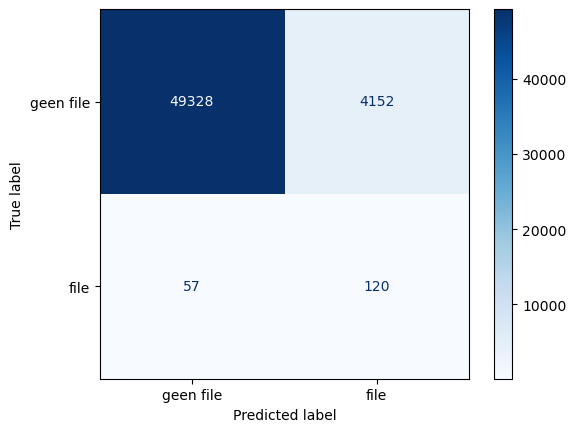

In [24]:
cm = confusion_matrix(y_test, y_pred_grid, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['geen file', 'file'])
disp.plot(cmap='Blues')

De confusion matrix maakt de onhoudbaarheid van het model nog zichtbaarder. Hoewel de 3 op 97 ratio al duidt op een zwak resultaat, toont de matrix de schaal van de fouten: er wordt ongeveer 4300 keer voorspeld dat er een file zal komen op een dataset van zo'n 53.000 metingen. Dat is veel, al helemaal als je in consideratie neemt dat slechts 120 van deze voorspellingen correct zijn en er dus 4152 overbodig maatregel genomen zou worden om slechts 120 files te vermijden.


### Vervolg
De experimenten met hyperparameter tuning, threshold-optimalisatie en verschillende undersampling-ratio's laten zien dat de beperking niet in de instellingen van het algoritme ligt, maar in de informatiebehoefte van het model. De miniscule verbeteringen die deze methoden boden, wegen niet op tegen het grote verlies aan recall.

Hoewel de resultaten aantonen dat verkeersintensiteit de belangrijkste voorspeller is, blijkt dit in de praktijk onvoldoende context te bieden. Een hoge intensiteit is een voorwaarde voor filevorming, maar leidt niet noodzakelijkerwijs tot een omslagpunt. Dit verklaart het hoge aantal vals-positieve meldingen.

Er zijn enkele factoren die niet aangepast zijn in dit verslag maar wel degelijk invloed kunnen hebben op de resultaten:
* Een beter gebalanceerde dataset zou betere resultaten kunnen opleveren. Door niet alle files mee te nemen en specifiek ongelukken en andere onvoorzienbare files uit de data te filteren wordt de data representatiever van het daadwerkelijke verkeerspatroon. Ook kan er selectiever omgegaan worden met de undersampling, i.p.v. dit willekeurig te doen.
* Er kunnen nog meer context features worden toegevoegd aan de featureset zoals: het weer, externe jaarlijkse evenementen, een cyclische tijd (i.p.v. enkel een nummerieke tijd), etc.
* Alternatieve modellen: hoewel random forest een prima model is voor patroonherkenning, zijn er modellen die beter met tijdpatronen om kunnen gaan. Zo kunnen gradient boosting algoritmes of deep learning algoritmes meer potentie houden voor het oplossen van dit probleem.

Al wordt er benoemd dat deze stappen mogelijk verbetering kunnen opleveren, is er nog grote twijfel bij of deze factoren genoeg veranderen om een accurate voorspelling te doen op basis van de intensiteit.